In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
X_train_raw = train.drop(columns=['label']).to_numpy()
y_train_raw = train['label'].to_numpy()

In [4]:
print(X_train_raw.shape)
print(y_train_raw.shape)

(42000, 784)
(42000,)


In [5]:
x_mean = np.mean(X_train_raw)
x_std = np.std(X_train_raw)

def standarize(X):
    return (X - x_mean) / x_std

X_train = np.reshape(X_train_raw,(-1,28,28,1))
X_train = standarize(X_train)

y_train_cat = keras.utils.to_categorical(y_train_raw)

In [6]:
y_train_cat.shape

(42000, 10)

In [7]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

data_generator.fit(X_train)

In [8]:
def make_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=3,activation='relu',kernel_initializer='he_normal',input_shape=(28, 28, 1)))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Conv2D(32, kernel_size=3,activation='relu'))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same',activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Conv2D(64, kernel_size=3, activation ='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, kernel_size=3, activation ='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same',activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation = "relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation = "softmax"))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
ens_size=16
model = [0]*ens_size

for i in range(ens_size):
    model[i] = make_model()

In [10]:
import time
history = [0]*ens_size


start = time.perf_counter()

for i in range(ens_size):
    callbacks = [keras.callbacks.ModelCheckpoint('/kaggle/working/mdl-{}-of-{}.hdf5'
                                                 .format(i,ens_size-1),save_best_only=True, monitor='val_accuracy', mode='max')]
    
    X_train_ens, X_valid_ens, y_train_ens, y_valid_ens = train_test_split(X_train, y_train_cat, train_size=0.9)
    train_aug = data_generator.flow(X_train_ens, y_train_ens)
    
    history[i] = model[i].fit_generator(train_aug, epochs=40,
                              validation_data=(X_valid_ens, y_valid_ens),
                              callbacks=callbacks, verbose = 0)
    
    print("CNN {}: Train accuracy={:0.5f}, Validation accuracy={:0.5f}"
      .format(i,max(history[i].history['accuracy']),max(history[i].history['val_accuracy']) ))
    
stop = time.perf_counter()
print(f"{stop - start:0.4f}")

CNN 0: Train accuracy=0.99291, Validation accuracy=0.99548
CNN 1: Train accuracy=0.99294, Validation accuracy=0.99571
CNN 2: Train accuracy=0.99312, Validation accuracy=0.99786
CNN 3: Train accuracy=0.99280, Validation accuracy=0.99619
CNN 4: Train accuracy=0.99347, Validation accuracy=0.99714
CNN 5: Train accuracy=0.99259, Validation accuracy=0.99595
CNN 6: Train accuracy=0.99294, Validation accuracy=0.99452
CNN 7: Train accuracy=0.99272, Validation accuracy=0.99619
CNN 8: Train accuracy=0.99325, Validation accuracy=0.99476
CNN 9: Train accuracy=0.99299, Validation accuracy=0.99762
CNN 10: Train accuracy=0.99272, Validation accuracy=0.99595
CNN 11: Train accuracy=0.99328, Validation accuracy=0.99643
CNN 12: Train accuracy=0.99307, Validation accuracy=0.99619
CNN 13: Train accuracy=0.99270, Validation accuracy=0.99714
CNN 14: Train accuracy=0.99312, Validation accuracy=0.99643
CNN 15: Train accuracy=0.99272, Validation accuracy=0.99643
9060.3379


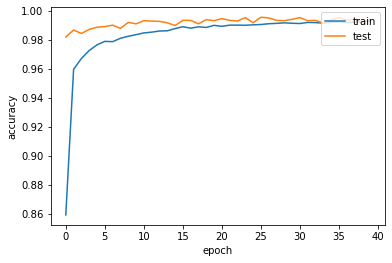

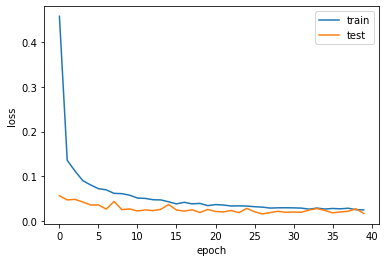

In [11]:
import matplotlib.pyplot as plt

def visualize_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

def visualize_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
visualize_accuracy(history[0])
visualize_loss(history[0])

In [12]:
X_test = np.reshape(test.to_numpy(),(-1,28,28,1))
X_test = standarize(X_test)

In [13]:
preds = np.zeros((X_test.shape[0],10))

for i in range(ens_size):
    mdl = keras.models.load_model('/kaggle/working/mdl-{}-of-{}.hdf5'.format(i,ens_size-1))
    preds = preds + mdl.predict(X_test)

In [14]:
submit_pred = np.argmax(preds,axis=1)
submit_pred.shape

(28000,)

In [15]:
submition = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submition['Label'] = submit_pred

In [16]:
submition.to_csv('/kaggle/working/submition_ens3.csv', index=False)